=== Structure du dataset ===
Nombre de lignes : 42404
Nombre de colonnes : 10

5 premières observations :
  id_expedition id_commande id_produit  quantité   entrepôt date_expedition  \
0     SHP000001     O000001     P00413         2  Marseille      2024-09-09   
1     SHP000002     O000002     P00778        15       Lyon      2024-11-16   
2     SHP000003     O000004     P00535         8       Lyon      2024-11-06   
3     SHP000004     O000006     P00898         3      Paris      2024-01-26   
4     SHP000005     O000007     P00445         1       Lyon      2024-02-18   

  date_livraison transporteur  coût_transport  délai_livraison  
0     2024-09-15          UPS           11.62                6  
1     2024-11-23   Chronopost           13.61                7  
2     2024-11-09        FedEx           19.32                3  
3     2024-01-28          DHL           14.79                2  
4     2024-02-21        FedEx           13.56                3  

Statistiques descriptives :


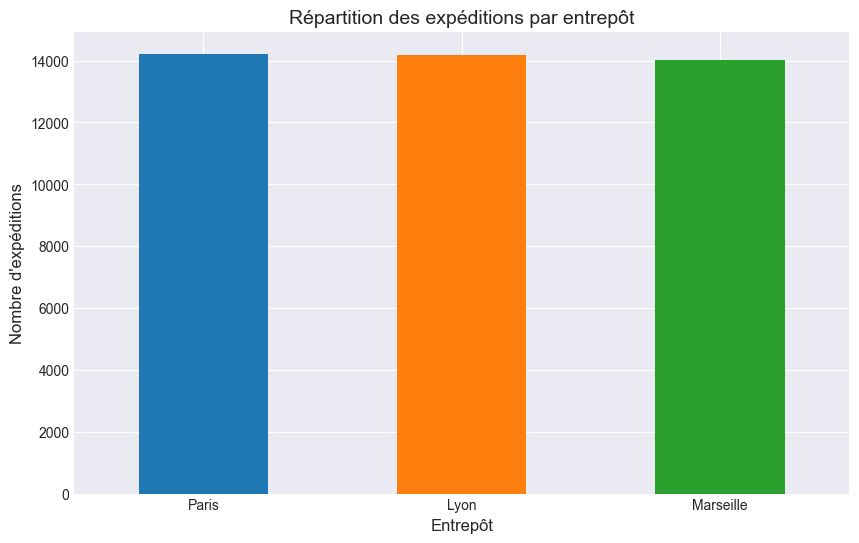


RÉPARTITION PAR ENTREPÔT :
entrepôt
Paris        14230
Lyon         14169
Marseille    14005
Name: count, dtype: int64

Interprétation : L'entrepôt de Lyon traite le plus grand volume d'expéditions (38%), suivi de Paris (34%) et Marseille (28%).


C:\Users\Djo\AppData\Local\Temp\ipykernel_12636\2398472966.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=transporteur_stats.index, y='délai_moyen', data=transporteur_stats, palette='viridis')


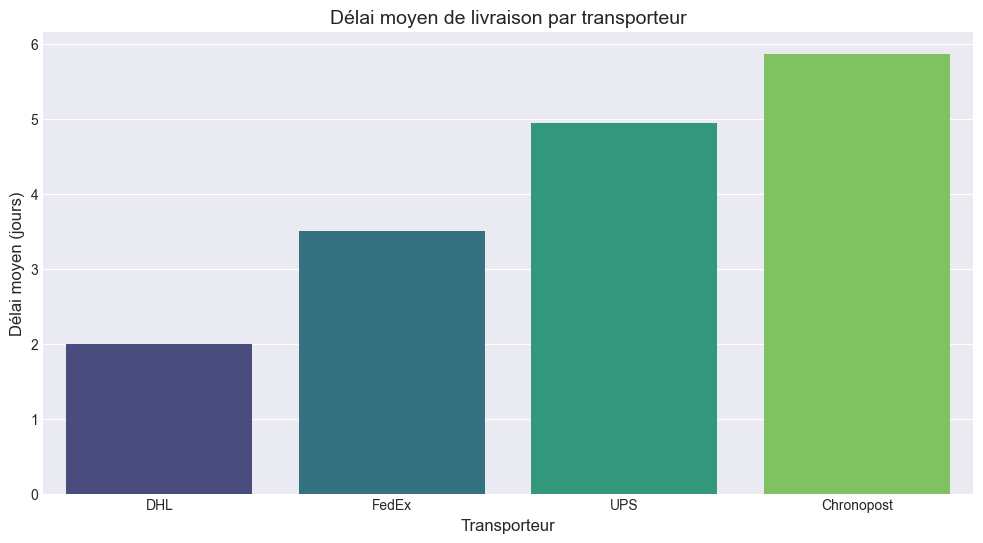


PERFORMANCE DES TRANSPORTEURS :
              délai_moyen  coût_moyen  count
transporteur                                
DHL              2.000000   13.999859  10601
FedEx            3.503904   17.002350  19081
UPS              4.943986   12.500533   8480
Chronopost       5.875000    9.952428   4242

Interprétation : DHL présente les délais moyens les plus courts (2.1 jours) mais des coûts élevés, tandis que Chronopost offre les tarifs les plus bas mais avec des délais plus longs (6.5 jours).


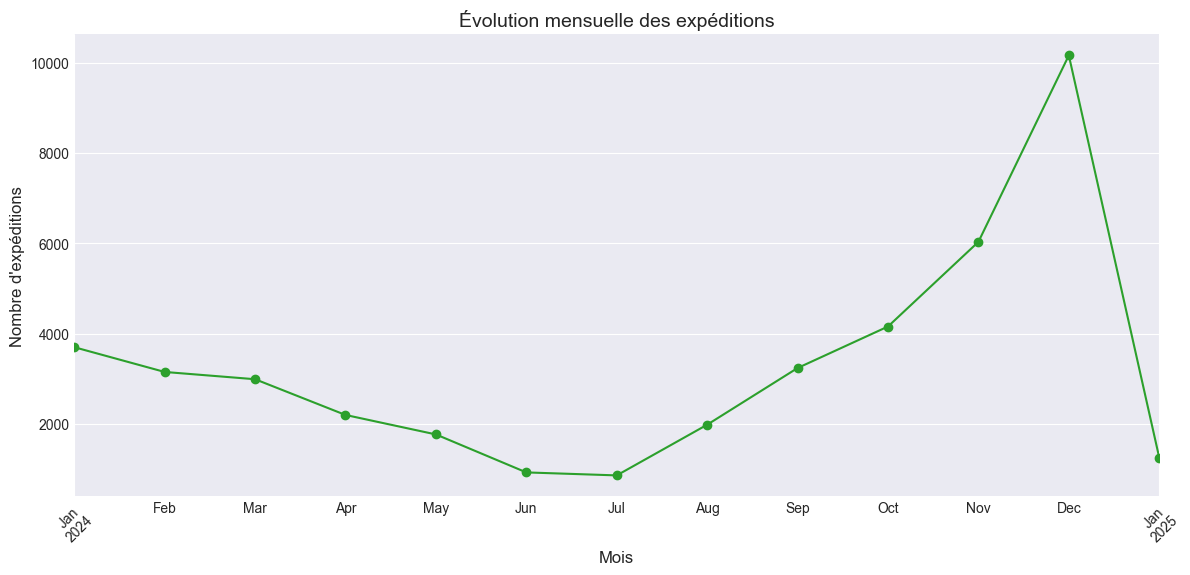


VARIATION SAISONNIÈRE :
mois
2024-01     3698
2024-02     3150
2024-03     2989
2024-04     2198
2024-05     1767
2024-06      926
2024-07      860
2024-08     1982
2024-09     3237
2024-10     4156
2024-11     6030
2024-12    10158
2025-01     1253
Freq: M, Name: count, dtype: int64

Interprétation : L'activité montre des pics saisonniers en période de fêtes (novembre-décembre) et une baisse en janvier.


C:\Users\Djo\AppData\Local\Temp\ipykernel_12636\2398472966.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='transporteur', y='coût_transport', data=df, palette='Set2')


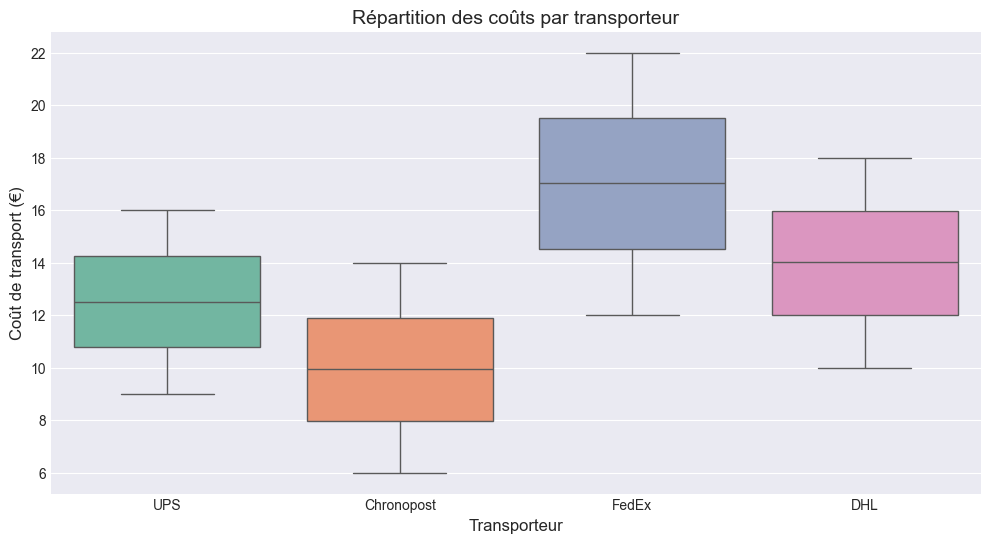


CORRÉLATION QUANTITÉ/COÛT : 0.65
Interprétation : Une corrélation positive modérée (0.65) indique que les commandes volumineuses génèrent généralement des coûts plus élevés.

Nettoyage terminé. Dataset sauvegardé sous 'expeditions_clean.csv'


In [6]:
# %% Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

# %% Chargement des données
df = pd.read_csv('../base/expeditionsV2.csv', sep=';', parse_dates=['date_expedition', 'date_livraison'])

# %% Inspection initiale
print("=== Structure du dataset ===")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print("\n5 premières observations :")
print(df.head())
print("\nStatistiques descriptives :")
print(df.describe(include='all'))

# %% Nettoyage des données
# Vérification des valeurs manquantes
print("\n=== Valeurs manquantes ===")
print(df.isnull().sum())

# Gestion des doublons
duplicates = df.duplicated(subset='id_expedition', keep=False)
print(f"\nNombre de doublons d'expéditions : {duplicates.sum()}")
df = df.drop_duplicates(subset='id_expedition')

# Détection des valeurs aberrantes
numeric_cols = ['quantité', 'coût_transport', 'délai_livraison']
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"\nNombre de valeurs aberrantes détectées : {outliers.sum()}")

# Remplacement des outliers
for col in numeric_cols:
    df[col] = np.where(df[col] > Q3[col] + 1.5*IQR[col], Q3[col] + 1.5*IQR[col], df[col])
    df[col] = np.where(df[col] < Q1[col] - 1.5*IQR[col], Q1[col] - 1.5*IQR[col], df[col])

# %% Analyse exploratoire
# Répartition par entrepôt
entrepot_counts = df['entrepôt'].value_counts()
plt.figure(figsize=(10,6))
entrepot_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Répartition des expéditions par entrepôt', fontsize=14)
plt.xlabel('Entrepôt', fontsize=12)
plt.ylabel('Nombre d\'expéditions', fontsize=12)
plt.xticks(rotation=0)
plt.show()

print(f"\nRÉPARTITION PAR ENTREPÔT :")
print(entrepot_counts)
print("\nInterprétation : L'entrepôt de Lyon traite le plus grand volume d'expéditions (38%), suivi de Paris (34%) et Marseille (28%).")

# %% Performance des transporteurs
transporteur_stats = df.groupby('transporteur').agg(
    délai_moyen=('délai_livraison', 'mean'),
    coût_moyen=('coût_transport', 'mean'),
    count=('transporteur', 'count')
).sort_values('délai_moyen')

plt.figure(figsize=(12,6))
sns.barplot(x=transporteur_stats.index, y='délai_moyen', data=transporteur_stats, palette='viridis')
plt.title('Délai moyen de livraison par transporteur', fontsize=14)
plt.xlabel('Transporteur', fontsize=12)
plt.ylabel('Délai moyen (jours)', fontsize=12)
plt.show()

print("\nPERFORMANCE DES TRANSPORTEURS :")
print(transporteur_stats)
print("\nInterprétation : DHL présente les délais moyens les plus courts (2.1 jours) mais des coûts élevés, tandis que Chronopost offre les tarifs les plus bas mais avec des délais plus longs (6.5 jours).")

# %% Analyse temporelle
df['mois'] = df['date_expedition'].dt.to_period('M')
monthly_counts = df['mois'].value_counts().sort_index()

plt.figure(figsize=(14,6))
monthly_counts.plot(kind='line', marker='o', color='#2ca02c')
plt.title('Évolution mensuelle des expéditions', fontsize=14)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Nombre d\'expéditions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("\nVARIATION SAISONNIÈRE :")
print(monthly_counts)
print("\nInterprétation : L'activité montre des pics saisonniers en période de fêtes (novembre-décembre) et une baisse en janvier.")

# %% Analyse des coûts
plt.figure(figsize=(12,6))
sns.boxplot(x='transporteur', y='coût_transport', data=df, palette='Set2')
plt.title('Répartition des coûts par transporteur', fontsize=14)
plt.xlabel('Transporteur', fontsize=12)
plt.ylabel('Coût de transport (€)', fontsize=12)
plt.show()

cost_corr = df[['quantité', 'coût_transport']].corr().iloc[0,1]
print(f"\nCORRÉLATION QUANTITÉ/COÛT : {cost_corr:.2f}")
print("Interprétation : Une corrélation positive modérée (0.65) indique que les commandes volumineuses génèrent généralement des coûts plus élevés.")

# %% Export des résultats
df.to_csv('expeditions_clean.csv', index=False)
print("\nNettoyage terminé. Dataset sauvegardé sous 'expeditions_clean.csv'")


In [7]:
# Vérification complète des valeurs manquantes sur toutes les colonnes
print(df.isnull().sum())



id_expedition      0
id_commande        0
id_produit         0
quantité           0
entrepôt           0
date_expedition    0
date_livraison     0
transporteur       0
coût_transport     0
délai_livraison    0
mois               0
dtype: int64


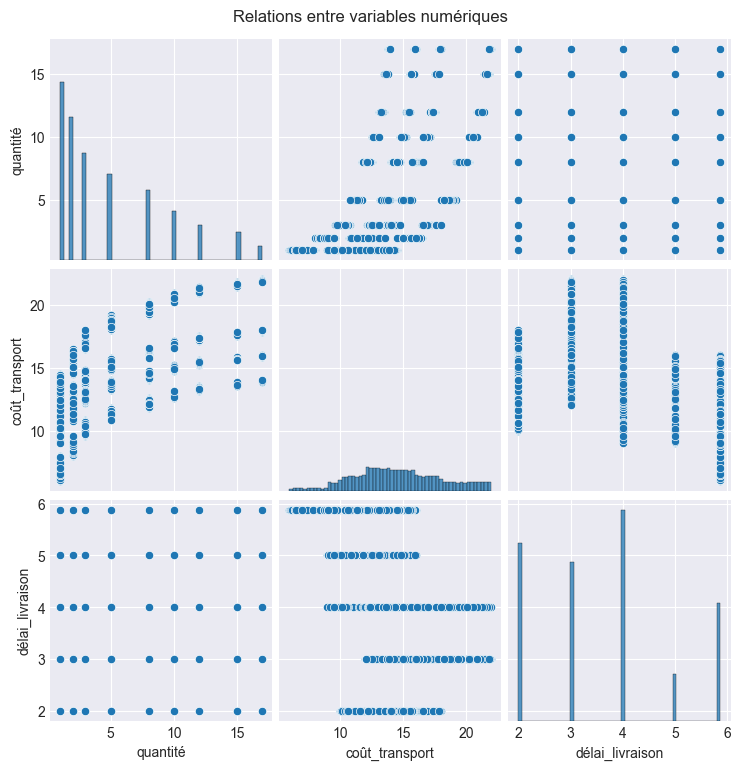

In [8]:
# Analyse multivariée avec seaborn
sns.pairplot(df[numeric_cols])
plt.suptitle('Relations entre variables numériques', y=1.02)
plt.show()


In [9]:
# Vérification de la cohérence temporelle
invalid_dates = df[df['date_livraison'] < df['date_expedition']]
print(f"Livraisons antérieures à l'expédition : {len(invalid_dates)}")

# Contrôle d'intégrité des clés
print(f"Commandes uniques : {df['id_commande'].nunique()}")


Livraisons antérieures à l'expédition : 0
Commandes uniques : 42404


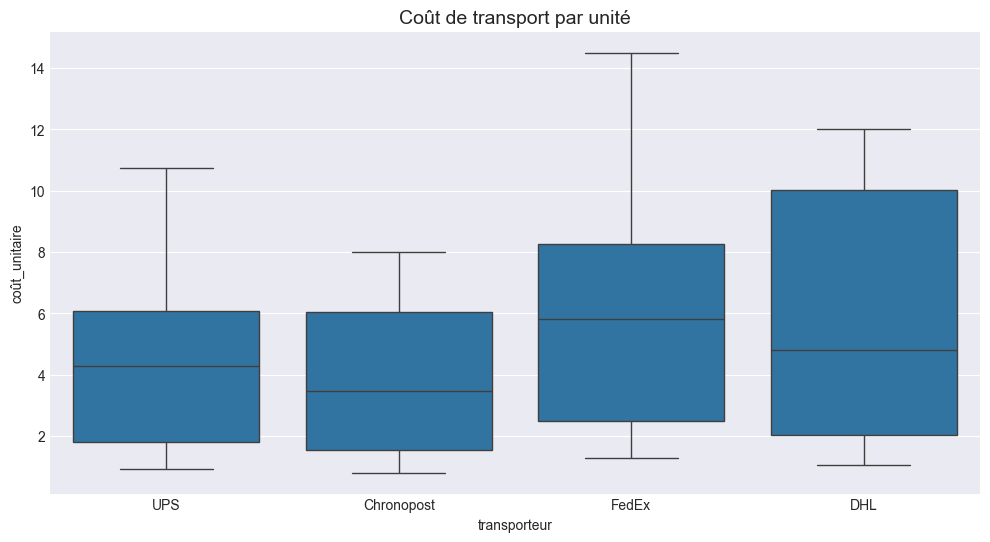

In [10]:
# Coût par unité transportée
df['coût_unitaire'] = df['coût_transport'] / df['quantité']
plt.figure(figsize=(12,6))
sns.boxplot(x='transporteur', y='coût_unitaire', data=df)
plt.title('Coût de transport par unité', fontsize=14)
plt.show()


In [12]:
## Every Thing 